## Probability Density Function (PDF) Estimation 

A random variable x has a probability distribution $ p(x) $.

In this notebook we look at generating PDF functions for data, also known as PDF estimation. 




In [17]:
######################################################
##
## Probability Density Function (PDF) Estimation
##
######################################################

import torch
import numpy as np
import pandas as pd
import sklearn
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from mlxtend.plotting import heatmap
from numpy.random import normal
from scipy.stats import norm
import scipy.stats as stats
from numpy import hstack
from numpy import asarray
from numpy import exp
from sklearn.neighbors import KernelDensity

## coefficient of determination (R**2)
from sklearn.metrics import r2_score


#######################################################

N_EPOCHS = 50000
batch_size = 10
learning_rate =  0.01    ## 0.01   ## 1e-5 

## probably need adjustable learning rate scheduler

#######################################################

np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)

#######################################################

## Probability Distributions

Common probability distributions include uniform, normal, exponential, binomial, poisson, etc.



## Binomial Distribution

It summarizes the likelihood that a variable will take one of two possible values. This is useful when solutions are true or false, yes or not, positive or negative, etc. Also known as Bernoulli experiments. The PDF function for binomial is:


$ \large f(x) = {n \choose k} p^k (1-p)^{n-k}   $

where

$  \large [0, 1, ..., n]   $ 

and 

$ \large 0 <= p <= 1  $


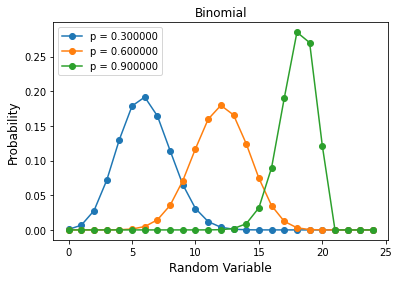

In [18]:

for prob in range(3, 10, 3):
    x = np.arange(0, 25)
    binom = stats.binom.pmf(x, 20, 0.1*prob)
    plt.plot(x, binom, '-o', label="p = {:f}".format(0.1*prob))
    plt.xlabel('Random Variable', fontsize=12)
    plt.ylabel('Probability', fontsize=12)
    plt.title("Binomial")
    plt.legend()
plt.show()


## Poisson Distribution

A type of discrete probability distribution which represents the probability of a number of events that can happen in a fixed period of time. It represents how many times an event can occur over a specific time period. The Poisson PDF function is as follows:


$ \large f(k) = e^{- \mu} \frac{\mu^k}{k!}  $

for k >= 0




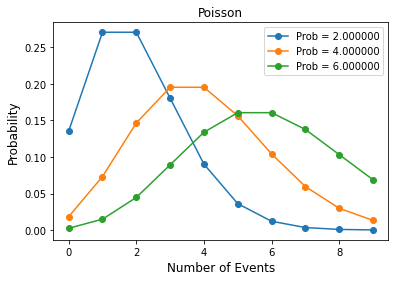

In [19]:
for lambd in range(2, 8, 2):
    n = np.arange(0, 10)
    poisson = stats.poisson.pmf(n, lambd)
    plt.plot(n, poisson, '-o', label="Prob = {:f}".format(lambd))
    plt.xlabel('Number of Events', fontsize=12)
    plt.ylabel('Probability', fontsize=12)
    plt.title("Poisson")
    plt.legend()

plt.show()
    


## Uniform Distribution

A continuous type of distribution which represents that all events can occur with the same probability. The PDF function is as follows:

for a <= x <= b then:


$ \large f(x)= \frac {1}{b-a}    $

for x < a or x > b then:

0

(0.0, 1.0)

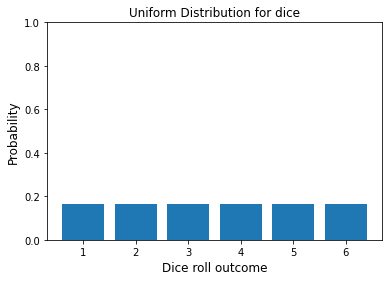

In [20]:

probs = np.full((6), 1/6)
face = [1, 2, 3, 4, 5, 6]
plt.bar(face, probs)
plt.xlabel('Dice roll outcome', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.title("Uniform Distribution for dice")

axes = plt.gca()
axes.set_ylim([0, 1])


## Normal or Gaussian distribution

This is for continuous data. The PDF function is:

$ \large  f(x) = (\frac {1}{ \sqrt{2 \pi}}) e^{\frac {-x^2}{2}}   $

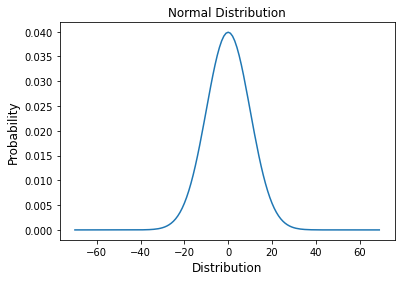

In [21]:

n = np.arange(-70, 70)
normal_viz = stats.norm.pdf(n, 0, 10)
plt.plot(n, normal_viz)
plt.xlabel('Distribution', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.title("Normal Distribution")
plt.show()


## Basic PDF estimation from data

Here we generate some data and then proceed to fit the PDF function. There are 2 types of fitting:

* Parametric

* Non-parametric


## Generate some data and show the histogram

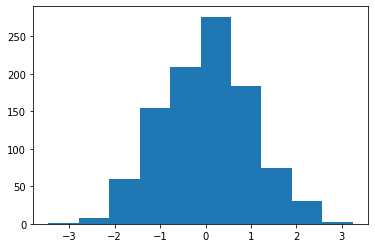

In [22]:

sample = normal(size=1000)


plt.hist(sample, bins=10)
plt.show()


## Parametric Density Estimation

First identify one of the common probability distributions, and then you estimate the parameters for it. 

In [23]:

## loc -> mean -> 50
## scale -> standard deviation -> 5

sample = normal(loc=50, scale=5, size=1000)

In [24]:
## calculate parameters

sample_mean         = np.mean(sample)
sample_standard_dev = np.std(sample)

print('mean=%.3f, Standard Deviation=%.3f' % (sample_mean, sample_standard_dev))

mean=49.905, Standard Deviation=4.983


## Define the normal distribution function with learned parameters



In [25]:


dist = norm(sample_mean, sample_standard_dev)



## Now sample probabilities from this distribution for a range of values

In [26]:
## sample probabilities for a range of values

values = [value for value in range(30 ,70)]

probabilities = [dist.pdf(value) for value in values]

print(probabilities)


[2.7454014930899316e-05, 5.997880528967832e-05, 0.0001258634700932241, 0.00025369478308597497, 0.0004911716785727436, 0.0009134084868278527, 0.0016315737633261934, 0.0027993572659838336, 0.004613387017092036, 0.007302833426129573, 0.011103831055288366, 0.016216765662671054, 0.022749171345029337, 0.0306532740219559, 0.03967327917586492, 0.04932070481151758, 0.058893910914716685, 0.06754939458589014, 0.07441876730286462, 0.07875051959447883, 0.0800450221189901, 0.07814931488658529, 0.07328683494687199, 0.06601409932366152, 0.05711594720107762, 0.04746658743700592, 0.03789034685701779, 0.029052204814073106, 0.02139634335418439, 0.015135959775860115, 0.010284668936506262, 0.0067124430298265165, 0.004208049639350743, 0.0025339091557661144, 0.0014655855429382063, 0.0008142190306912317, 0.00043449148580113647, 0.0002227056510535211, 0.00010964558496980117, 5.185146192963065e-05]


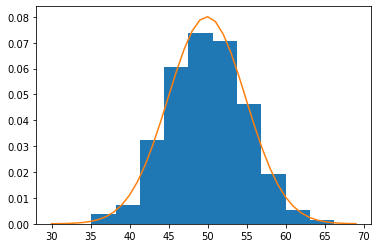

In [27]:

## plot the histogram and PDF

## plt.hist(sample, bins=10)                       ## shows the count
plt.hist(sample, bins=10, density=True)      ## shows a normalized probability instead of counts
plt.plot(values, probabilities)
plt.show()



## Nonparametric Density Estimation

This approach is useful when there is no clear distribution from observation but you can still create a pdf.

Possibly, the most common non-parametric approach for estimating the PDF of a random variable is "Kernel Smoothing" or "Kernel Density Estimation (KDE)". In this case, a kernel is a mathematical function that returns a probability for a given value of a random variable. 

I think this is a sum of basis functions to approximate a new PDF function where the area equals to 1. 

## First generate the data with no clear known distribution

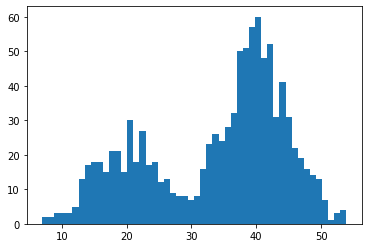

In [28]:

sample1 = normal(loc=20, scale=5, size=300)
sample2 = normal(loc=40, scale=5, size=700)

sample = hstack((sample1, sample2))
plt.hist(sample, bins=50)
plt.show()


## Now perform Kernel Density Estimation on this data to find the PDF

The data needs to have a 2D shape in the form (rows, columns).

In [29]:

## Bandwidth (smoothing parameter) is a window size required by the algorithm that controls 
## the number of observations (samples) to look at per new point to estimate. 
## The kernel is the basis function. 

model = KernelDensity(bandwidth=2, kernel='gaussian')

sample = sample.reshape((len(sample), 1))              ## 1000x1

model.fit(sample)


KernelDensity(bandwidth=2)

## Now compare the estimated PDF to the histogram

The model calculates the log probability for the input data with model.score_samples(). We then need to invert the log operation by calculating the exponent to return the values to the 0-1 range for normal probabilities. 

if

$ \large log_a b = c  $


then

$ \large a^c = b $

The irrational number $ e $ is also known as Euler’s number. It is approximately 2.718281, and is the base of the natural logarithm (ln). This means that, if 

$ \large x = \ln y = log_{e} y  $ 


then 

$  \large e^x = y  $


For real input, exp(x) is always positive.

In [30]:
values = asarray([value for value in range(1, 60)])
values = values.reshape((len(values), 1))
probabilities = model.score_samples(values)
print(probabilities)

[-12.52659392 -11.04674411  -9.77956223  -8.71524022  -7.84171386
  -7.14313209  -6.59646387  -6.16615023  -5.80155461  -5.45049261
  -5.09150825  -4.747303    -4.45623996  -4.24059402  -4.09802278
  -4.00830637  -3.94612441  -3.89364544  -3.84613995  -3.81007225
  -3.7980933   -3.82268655  -3.89007268  -3.99765042  -4.13529076
  -4.28664738  -4.42711508  -4.52042533  -4.52438548  -4.4190117
  -4.23347012  -4.02381921  -3.82843369  -3.6530594   -3.4851442
  -3.31740285  -3.16004474  -3.03301044  -2.95234995  -2.92472998
  -2.94890162  -3.0187853   -3.12662163  -3.26568271  -3.43053586
  -3.6151921   -3.81410547  -4.02829539  -4.26959045  -4.55523565
  -4.89583575  -5.28711621  -5.71671394  -6.18753534  -6.73327387
  -7.40464129  -8.24653665  -9.28916055 -10.55036535]


In [31]:
## now invert from log space to exponent space 

probabilities = exp(probabilities)
print(probabilities)

[0.00000363 0.00001594 0.0000566  0.00016407 0.00039299 0.00079027
 0.00136519 0.0020993  0.00302285 0.00429419 0.00614874 0.00867506
 0.01160592 0.01439904 0.01660548 0.01816413 0.01932947 0.02037095
 0.02136204 0.02214658 0.02241347 0.02186897 0.02044386 0.01835872
 0.01599801 0.01375095 0.01194891 0.01088439 0.01084137 0.01204613
 0.01450198 0.01788453 0.02174365 0.02591173 0.03064934 0.03624685
 0.04242384 0.04817041 0.05221685 0.05367918 0.05239723 0.04886053
 0.04386574 0.03817087 0.03236959 0.02691175 0.02205744 0.01780465
 0.01398751 0.01051202 0.00747766 0.00505632 0.00329051 0.00205489
 0.00119063 0.00060842 0.00026216 0.00009242 0.00002618]


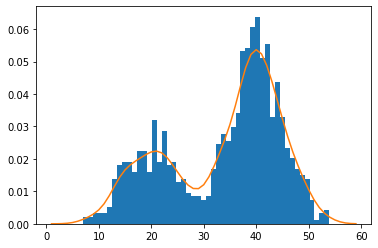

In [32]:

plt.hist(sample, bins=50, density=True)     ## see probs instead of counts with density=True
plt.plot(values[:], probabilities)          ## reshaped to 2D
plt.show()
